# Tráfico en Colombia con Random Forest

Autores: Laura Sofia Valencia Colman, Richard Stiv Murcia Huerfano

Este Notebook contiene todo el código de un modelo de Machine Learning ([Random Forest Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) de la libreria SkLearn) que predice el tráfico para los distintos 185 peajes de Colombia. Debido a que se trata de una regresión con múltiples variables (predictores), al final se muestran las graficas que resumen la predicción del tráfico en función de las distintas variables.

$Y_{Trafico} = f(X_{IdPeaje}, X_{IDC}, X_{Year}, X_{Month}, X_{Day}, X_{ValorTarifa})$

Este modelo de regresión obtuvo una métrica de medición del 96.3% para la fase de train y del 86% para la fase de test, lo que indica un sobreajuste en el modelo.

Finalmente, se realiza una evaluación del impacto de cada variable sobre el Trafico predicho usando los valores Shapley de la teoria de juegos con la libreria [SHAP](https://shap.readthedocs.io/en/latest/index.html).

## Instalación e Importación de Librerias

In [1]:
#Instalación de librerias faltantes.
!pip install geopandas shap

#Estructura de datos y graficos.
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
"""from matplotlib import pyplot as plt"""
import numpy as np
import matplotlib.pyplot as plt
"""import gzip"""
"""import shutil"""

#Modelo de Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

## Importación y Exploración de Datos

In [2]:
#Ubicación del dataset
peajes = "peajes_colombia.csv"

#Importación del Data Set
df_peajes = pd.read_csv(peajes, encoding= 'unicode_escape')

In [3]:
#Mostrando el Data Set
df_peajes.head()

,IdPeaje,Peaje,IdCategoriaTarifa,FechaDesde,FechaHasta,ValorTarifa,Trafico,TraficoEvasores,TraficoExentos787,Lat,Lon
0,1,ALVARADO,I,8/21/2015,8/31/2015,7000,27730,0.0,660.0,-74.991661,4.507609
1,1,ALVARADO,II,8/21/2015,8/31/2015,7600,9930,0.0,70.0,-74.991661,4.507609
2,1,ALVARADO,III,8/21/2015,8/31/2015,16100,1277,0.0,0.0,-74.991661,4.507609
3,1,ALVARADO,IV,8/21/2015,8/31/2015,20400,2074,0.0,0.0,-74.991661,4.507609
4,1,ALVARADO,V,8/21/2015,8/31/2015,22900,4167,0.0,0.0,-74.991661,4.507609


In [4]:
#Exploración de campos y tipos de dato  del Data Set
df_peajes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98306 entries, 0 to 98305
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IdPeaje            98306 non-null  int64  
 1   Peaje              98306 non-null  object 
 2   IdCategoriaTarifa  98306 non-null  object 
 3   FechaDesde         98306 non-null  object 
 4   FechaHasta         98306 non-null  object 
 5   ValorTarifa        98306 non-null  int64  
 6   Trafico            98306 non-null  int64  
 7   TraficoEvasores    96262 non-null  float64
 8   TraficoExentos787  96281 non-null  float64
 9   Lat                98306 non-null  float64
 10  Lon                98306 non-null  float64
dtypes: float64(4), int64(3), object(4)
memory usage: 8.3+ MB


In [5]:
df_peajes.describe()

,IdPeaje,ValorTarifa,Trafico,TraficoEvasores,TraficoExentos787,Lat,Lon
count,98306.000000,98306.000000,9.830600e+04,96262.000000,96281.00000,98306.000000,98306.000000
mean,63.206935,17331.696946,1.969663e+04,0.280651,181.99516,-74.665655,6.455282
std,42.886432,16308.602101,5.480460e+04,22.252275,703.30744,1.101541,2.611600
min,1.000000,0.000000,0.000000e+00,0.000000,0.00000,-77.408562,1.087343
25%,27.000000,6900.000000,3.110000e+02,0.000000,0.00000,-75.594025,4.454152
50%,58.000000,11100.000000,3.657000e+03,0.000000,0.00000,-74.808983,5.391559
75%,91.000000,24500.000000,1.395400e+04,0.000000,31.00000,-73.834808,8.845198
max,185.000000,142700.000000,1.120843e+06,4006.000000,101300.00000,-72.090698,11.444818


## Transformación de Datos

In [6]:
#Cambiando el tipo de dato a los campos de Fecha
df_peajes["FechaDesde"]=pd.to_datetime(df_peajes["FechaDesde"])
df_peajes["FechaHasta"]=pd.to_datetime(df_peajes["FechaHasta"])

In [7]:
#Eliminación de vacios
df_peajeslimpio = df_peajes.dropna()

#Verificación y eliminación de duplicados
df_peajeslimpio.drop_duplicates(inplace=True)

#Verificación de registros eliminados
df_peajeslimpio.shape


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(96262, 11)

Antes habian 98306 registros y ahora hay 96262, lo que representa una perdida del 2.1%

### Transformando Categorías de tarifas a valores numéricos

La categoría de los peajes en Colombia está dada por una etiqueta tipo *string*:

In [8]:
ctg = list(df_peajeslimpio["IdCategoriaTarifa"].unique())
print(ctg)

['I', 'II', 'III', 'IV', 'V', 'EA', 'EG', 'ER', 'IE', 'VI', 'VII', 'POLCA', 'IIE', 'IVE', 'IIIE', 'IEE', 'IEEE', 'VIII', 'IIA', 'IXE', 'IX', 'VE', 'VIE', 'VIIE', 'EC', 'VIIIE', 'IE10']


El modelo de regresión solo acepetará valores numéricos. Por lo anterior, se hace necesario asignar a cada categoría un valor entero.

In [9]:
#Creamos un diccionario que contendrá cada categoría con su valor numérico
categorias = {}
#Contador que resultará ser el valor numérico
count = 1
#Ciclo for que asigna a cada categoria de la lista ctg el valor numérico de count
for i in ctg:
  categorias[i] = count
  count += 1
#Imprimimos la salida y verificamos el resultado
print(categorias)

{'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'EA': 6, 'EG': 7, 'ER': 8, 'IE': 9, 'VI': 10, 'VII': 11, 'POLCA': 12, 'IIE': 13, 'IVE': 14, 'IIIE': 15, 'IEE': 16, 'IEEE': 17, 'VIII': 18, 'IIA': 19, 'IXE': 20, 'IX': 21, 'VE': 22, 'VIE': 23, 'VIIE': 24, 'EC': 25, 'VIIIE': 26, 'IE10': 27}


In [10]:
#Creamos una nueva columna llamada IDC la cual es una copia de IdCategoriaTarifa
df_peajeslimpio['IDC'] = df_peajeslimpio['IdCategoriaTarifa']
#Reemplazamos en IDC cada categoria por su valor numérico
df_peajeslimpio = df_peajeslimpio.replace({'IDC':categorias})
#Mostramos y verificamos el resultado
df_peajeslimpio.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,IdPeaje,Peaje,IdCategoriaTarifa,FechaDesde,FechaHasta,ValorTarifa,Trafico,TraficoEvasores,TraficoExentos787,Lat,Lon,IDC
0,1,ALVARADO,I,2015-08-21,2015-08-31,7000,27730,0.0,660.0,-74.991661,4.507609,1
1,1,ALVARADO,II,2015-08-21,2015-08-31,7600,9930,0.0,70.0,-74.991661,4.507609,2
2,1,ALVARADO,III,2015-08-21,2015-08-31,16100,1277,0.0,0.0,-74.991661,4.507609,3
3,1,ALVARADO,IV,2015-08-21,2015-08-31,20400,2074,0.0,0.0,-74.991661,4.507609,4
4,1,ALVARADO,V,2015-08-21,2015-08-31,22900,4167,0.0,0.0,-74.991661,4.507609,5


Se desea en un posterior trabajo, crear un mapa de Colombia con Geopandas ubicando la intensidad de tráfico en cada peaje del territorio nacional, por esto, se transforma el DataFrame de Pandas a Geopandas con el fin de manipular la Latitud y Longitud en formato Geometry.

In [11]:
# creating a geometry column
geometry = [Point(xy) for xy in zip(df_peajeslimpio['Lon'], df_peajeslimpio['Lat'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame
gdf_peajes = gpd.GeoDataFrame(df_peajeslimpio, crs=crs, geometry=geometry)

gdf_peajes.head()

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


,IdPeaje,Peaje,IdCategoriaTarifa,FechaDesde,FechaHasta,ValorTarifa,Trafico,TraficoEvasores,TraficoExentos787,Lat,Lon,IDC,geometry
0,1,ALVARADO,I,2015-08-21,2015-08-31,7000,27730,0.0,660.0,-74.991661,4.507609,1,POINT (4.50761 -74.99166)
1,1,ALVARADO,II,2015-08-21,2015-08-31,7600,9930,0.0,70.0,-74.991661,4.507609,2,POINT (4.50761 -74.99166)
2,1,ALVARADO,III,2015-08-21,2015-08-31,16100,1277,0.0,0.0,-74.991661,4.507609,3,POINT (4.50761 -74.99166)
3,1,ALVARADO,IV,2015-08-21,2015-08-31,20400,2074,0.0,0.0,-74.991661,4.507609,4,POINT (4.50761 -74.99166)
4,1,ALVARADO,V,2015-08-21,2015-08-31,22900,4167,0.0,0.0,-74.991661,4.507609,5,POINT (4.50761 -74.99166)


In [12]:
gdf_peajes.describe()

,IdPeaje,ValorTarifa,Trafico,TraficoEvasores,TraficoExentos787,Lat,Lon,IDC
count,96262.000000,96262.000000,9.626200e+04,96262.000000,96262.000000,96262.000000,96262.000000,96262.000000
mean,63.096746,17575.499159,1.998957e+04,0.280651,181.806601,-74.662903,6.449551,5.993663
std,42.751945,16373.414563,5.516177e+04,22.252275,702.877139,1.102927,2.612843,4.425453
min,1.000000,0.000000,0.000000e+00,0.000000,0.000000,-77.408562,1.087343,1.000000
25%,27.000000,7100.000000,3.290000e+02,0.000000,0.000000,-75.594025,4.452599,3.000000
50%,58.000000,11300.000000,3.799000e+03,0.000000,0.000000,-74.808983,5.391559,5.000000
75%,91.000000,24900.000000,1.425600e+04,0.000000,31.000000,-73.834808,8.845198,9.000000
max,185.000000,142700.000000,1.120843e+06,4006.000000,101300.000000,-72.090698,11.444818,27.000000


### Transformar fechas a digitos separados: Año, Mes, Día

Esto es importante porque nos permitirá analizar el tráfico por cada una de estas categorías.

In [13]:
gdf_peajes['FechaDesde']

0       2015-08-21
1       2015-08-21
2       2015-08-21
3       2015-08-21
4       2015-08-21
           ...    
98299   2022-02-01
98300   2022-02-01
98301   2022-02-01
98302   2022-02-01
98303   2022-02-01
Name: FechaDesde, Length: 96262, dtype: datetime64[ns]

In [14]:
# Convert datetime values into numerical features
gdf_peajes['Year'] = gdf_peajes.FechaDesde.dt.year
gdf_peajes['Month'] = gdf_peajes.FechaDesde.dt.month
gdf_peajes['Day'] = gdf_peajes.FechaDesde.dt.day
# Corresponding target values
gdf_peajes.head()

,IdPeaje,Peaje,IdCategoriaTarifa,FechaDesde,FechaHasta,ValorTarifa,Trafico,TraficoEvasores,TraficoExentos787,Lat,Lon,IDC,geometry,Year,Month,Day
0,1,ALVARADO,I,2015-08-21,2015-08-31,7000,27730,0.0,660.0,-74.991661,4.507609,1,POINT (4.50761 -74.99166),2015,8,21
1,1,ALVARADO,II,2015-08-21,2015-08-31,7600,9930,0.0,70.0,-74.991661,4.507609,2,POINT (4.50761 -74.99166),2015,8,21
2,1,ALVARADO,III,2015-08-21,2015-08-31,16100,1277,0.0,0.0,-74.991661,4.507609,3,POINT (4.50761 -74.99166),2015,8,21
3,1,ALVARADO,IV,2015-08-21,2015-08-31,20400,2074,0.0,0.0,-74.991661,4.507609,4,POINT (4.50761 -74.99166),2015,8,21
4,1,ALVARADO,V,2015-08-21,2015-08-31,22900,4167,0.0,0.0,-74.991661,4.507609,5,POINT (4.50761 -74.99166),2015,8,21


## Modelo: RandomForestRegressor de Sklearn
### Estructura datos entrenamiento y validación
80% para entrenar
20% para validar

In [15]:
X = gdf_peajes[['IdPeaje','IDC','Year','Month','Day','ValorTarifa']]
y = gdf_peajes['Trafico']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,IdPeaje,IDC,Year,Month,Day,ValorTarifa
25081,28,11,2019,1,16,61800
65863,80,3,2021,2,1,16100
21791,24,9,2019,7,1,3900
79754,99,3,2016,2,1,17900
30920,36,3,2015,2,1,15800


In [16]:
y_train.head()

25081     7997
65863    14375
21791     1528
79754     6451
30920     6857
Name: Trafico, dtype: int64

### Entrenamiento del Modelo

In [17]:
ml = RandomForestRegressor(n_estimators=100)
ml.fit(X_train, y_train)

RandomForestRegressor()

### Predicción y métrica

predict_train = ml.predict(X_train)
score = ml.score(X_train,y_train)
print("Metrica sobre el conjunto de entrenamiento", score_pred)
Metrica del modelo 0.9959

In [18]:
predictions = ml.predict(X_test)
score_pred = ml.score(X_test,y_test)
print("Metrica de la predicción", score_pred)

Metrica de la predicción 0.9637273256321198


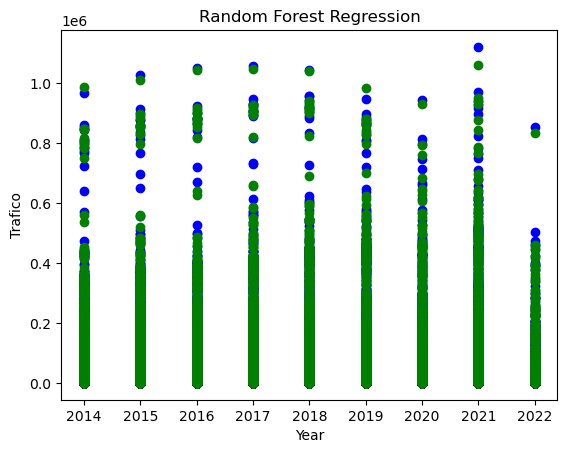

In [19]:
# Visualising the Random Forest Regression results

# Scatter plot for original data
plt.scatter(X['Year'], y, color='blue')

# plot predicted data
plt.scatter(X['Year'], ml.predict(X), color='green')
plt.title('Random Forest Regression')
plt.xlabel('Year')
plt.ylabel('Trafico')

plt.show()

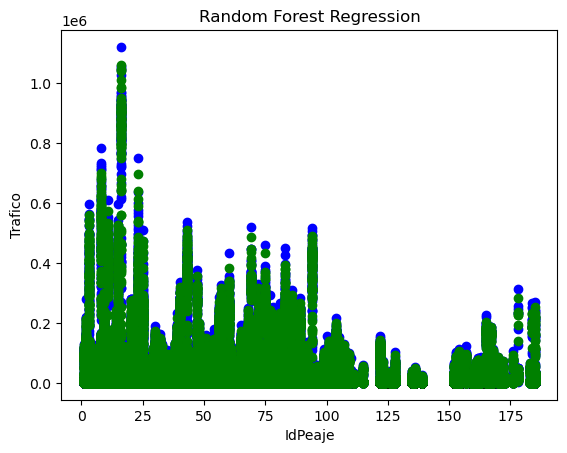

In [20]:
# Scatter plot for original data
plt.scatter(X['IdPeaje'], y, color='blue')

# plot predicted data
plt.scatter(X['IdPeaje'], ml.predict(X), color='green')
plt.title('Random Forest Regression')
plt.xlabel('IdPeaje')
plt.ylabel('Trafico')

plt.show()

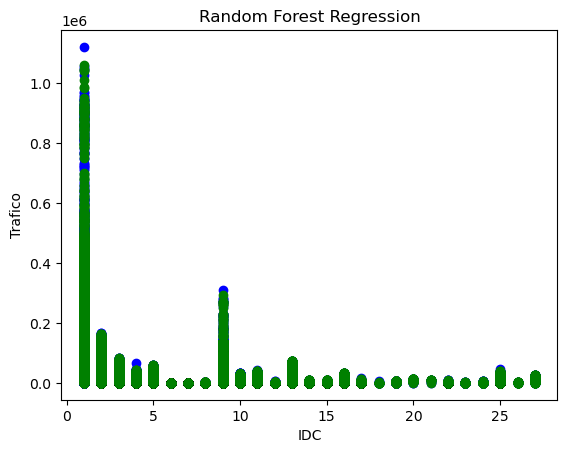

In [21]:
# Scatter plot for original data
plt.scatter(X['IDC'], y, color='blue')

# plot predicted data
plt.scatter(X['IDC'], ml.predict(X), color='green')
plt.title('Random Forest Regression')
plt.xlabel('IDC')
plt.ylabel('Trafico')

plt.show()

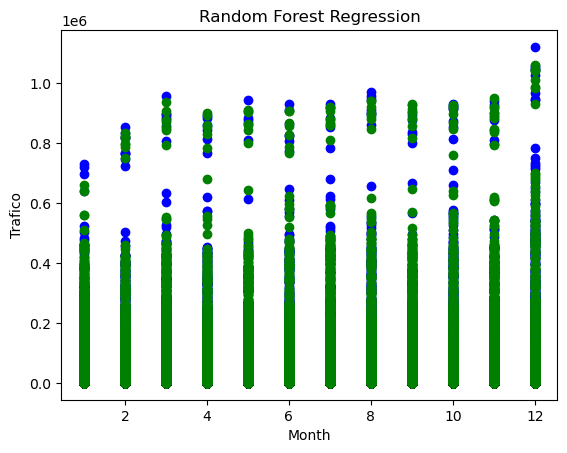

In [22]:
# Scatter plot for original data
plt.scatter(X['Month'], y, color='blue')

# plot predicted data
plt.scatter(X['Month'], ml.predict(X), color='green')
plt.title('Random Forest Regression')
plt.xlabel('Month')
plt.ylabel('Trafico')

plt.show()

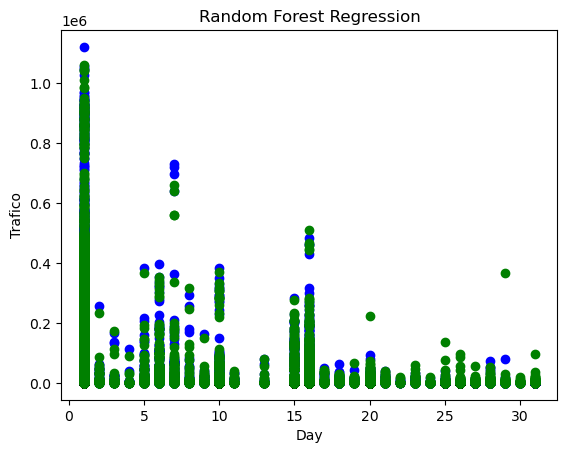

In [23]:
# Scatter plot for original data
plt.scatter(X['Day'], y, color='blue')

# plot predicted data
plt.scatter(X['Day'], ml.predict(X), color='green')
plt.title('Random Forest Regression')
plt.xlabel('Day')
plt.ylabel('Trafico')

plt.show()

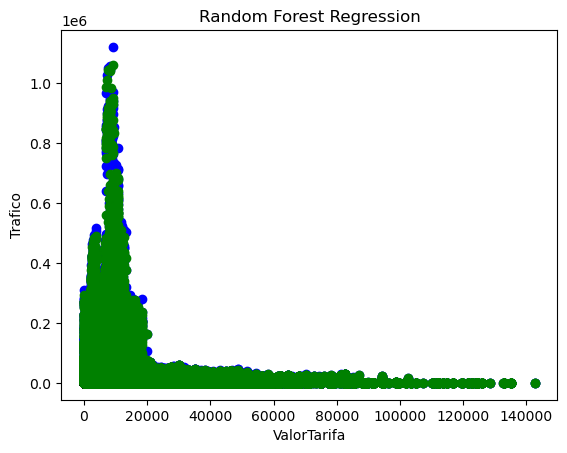

In [24]:
# Scatter plot for original data
plt.scatter(X['ValorTarifa'], y, color='blue')

# plot predicted data
plt.scatter(X['ValorTarifa'], ml.predict(X), color='green')
plt.title('Random Forest Regression')
plt.xlabel('ValorTarifa')
plt.ylabel('Trafico')

plt.show()

### Reentrenamiento hasta el 2021 y Predicción con 2022

In [25]:
gdf_peajes21 = gdf_peajes.drop(gdf_peajes[gdf_peajes['Year'] == 2022].index)
gdf_peajes21.head()

,IdPeaje,Peaje,IdCategoriaTarifa,FechaDesde,FechaHasta,ValorTarifa,Trafico,TraficoEvasores,TraficoExentos787,Lat,Lon,IDC,geometry,Year,Month,Day
0,1,ALVARADO,I,2015-08-21,2015-08-31,7000,27730,0.0,660.0,-74.991661,4.507609,1,POINT (4.50761 -74.99166),2015,8,21
1,1,ALVARADO,II,2015-08-21,2015-08-31,7600,9930,0.0,70.0,-74.991661,4.507609,2,POINT (4.50761 -74.99166),2015,8,21
2,1,ALVARADO,III,2015-08-21,2015-08-31,16100,1277,0.0,0.0,-74.991661,4.507609,3,POINT (4.50761 -74.99166),2015,8,21
3,1,ALVARADO,IV,2015-08-21,2015-08-31,20400,2074,0.0,0.0,-74.991661,4.507609,4,POINT (4.50761 -74.99166),2015,8,21
4,1,ALVARADO,V,2015-08-21,2015-08-31,22900,4167,0.0,0.0,-74.991661,4.507609,5,POINT (4.50761 -74.99166),2015,8,21


#### Separación de conjunto Train y Test

In [26]:
X = gdf_peajes21[['IdPeaje','IDC','Year','Month','Day','ValorTarifa']]
y = gdf_peajes21['Trafico']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Entrenamiento de nuevo modelo

In [27]:
ml = RandomForestRegressor(n_estimators=100)
ml.fit(X_train, y_train)
predict_train = ml.predict(X_train)
score = ml.score(X_train,y_train)
print("Metrica del modelo", score)

Metrica del modelo 0.9961990066116798


In [28]:
predictions = ml.predict(X_test)
score_pred = ml.score(X_test,y_test)
print("Metrica de la predección", score_pred)

Metrica de la predección 0.9702124234054562


### DataFrame del 2022

In [29]:
gdf_peajes22 = gdf_peajes.drop(gdf_peajes[gdf_peajes['Year'] != 2022].index)
X22 = gdf_peajes22[['IdPeaje','IDC','Year','Month','Day','ValorTarifa']]
y22 = gdf_peajes22['Trafico']
gdf_peajes22.head()

,IdPeaje,Peaje,IdCategoriaTarifa,FechaDesde,FechaHasta,ValorTarifa,Trafico,TraficoEvasores,TraficoExentos787,Lat,Lon,IDC,geometry,Year,Month,Day
711,1,ALVARADO,I,2022-01-01,2022-01-15,11300,77233,0.0,711.0,-74.991661,4.507609,1,POINT (4.50761 -74.99166),2022,1,1
712,1,ALVARADO,II,2022-01-01,2022-01-15,12000,4369,0.0,34.0,-74.991661,4.507609,2,POINT (4.50761 -74.99166),2022,1,1
713,1,ALVARADO,III,2022-01-01,2022-01-15,12500,3269,0.0,29.0,-74.991661,4.507609,3,POINT (4.50761 -74.99166),2022,1,1
714,1,ALVARADO,IV,2022-01-01,2022-01-15,13100,4748,0.0,7.0,-74.991661,4.507609,4,POINT (4.50761 -74.99166),2022,1,1
715,1,ALVARADO,V,2022-01-01,2022-01-15,27800,1942,0.0,2.0,-74.991661,4.507609,5,POINT (4.50761 -74.99166),2022,1,1


In [30]:
predictions = ml.predict(X22)
score_pred = ml.score(X22,y22)
print("Metrica de la predección", score_pred)

Metrica de la predección 0.8676357868141639


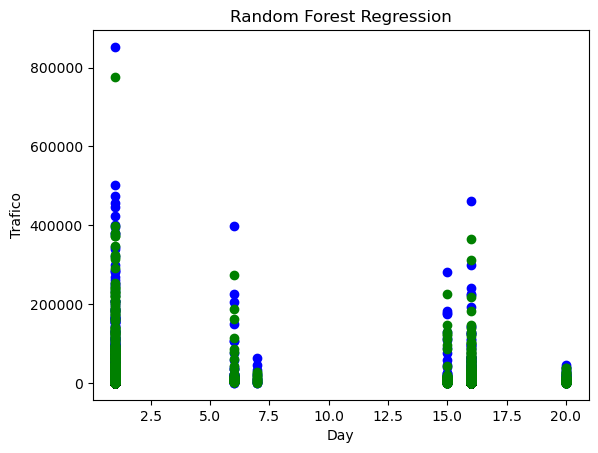

In [31]:
# Scatter plot for original data
plt.scatter(X22['Day'], y22, color='blue')

# plot predicted data
plt.scatter(X22['Day'], predictions, color='green')
plt.title('Random Forest Regression')
plt.xlabel('Day')
plt.ylabel('Trafico')

plt.show()

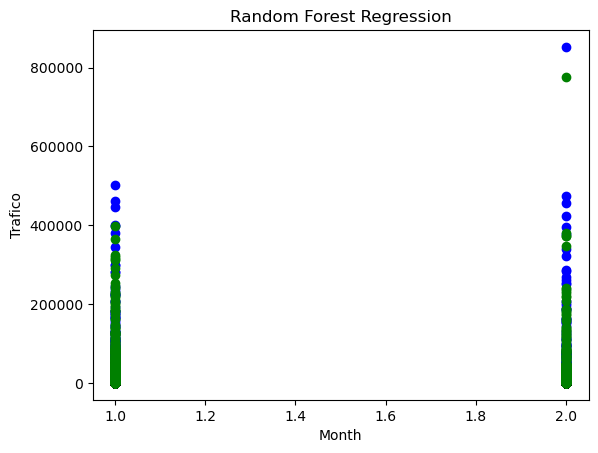

In [32]:
# Scatter plot for original data
plt.scatter(X22['Month'], y22, color='blue')

# plot predicted data
plt.scatter(X22['Month'], predictions, color='green')
plt.title('Random Forest Regression')
plt.xlabel('Month')
plt.ylabel('Trafico')

plt.show()

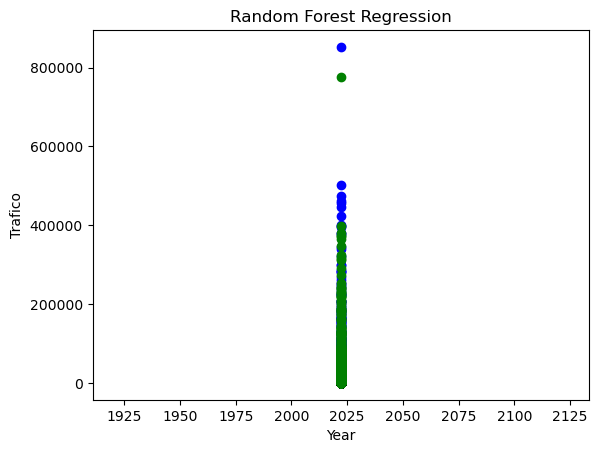

In [33]:
# Scatter plot for original data
plt.scatter(X22['Year'], y22, color='blue')

# plot predicted data
plt.scatter(X22['Year'], predictions, color='green')
plt.title('Random Forest Regression')
plt.xlabel('Year')
plt.ylabel('Trafico')

plt.show()

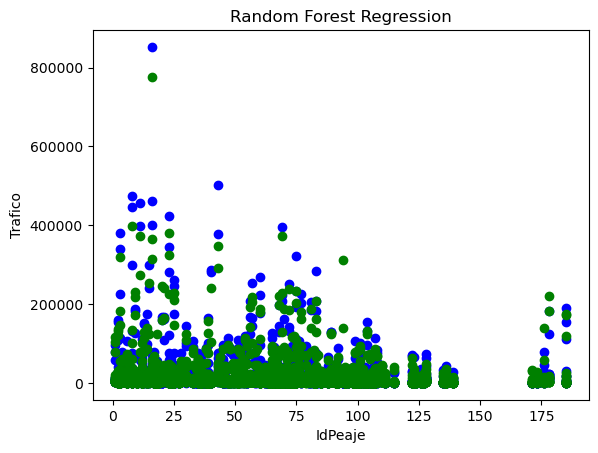

In [34]:
# Scatter plot for original data
plt.scatter(X22['IdPeaje'], y22, color='blue')

# plot predicted data
plt.scatter(X22['IdPeaje'], predictions, color='green')
plt.title('Random Forest Regression')
plt.xlabel('IdPeaje')
plt.ylabel('Trafico')

plt.show()

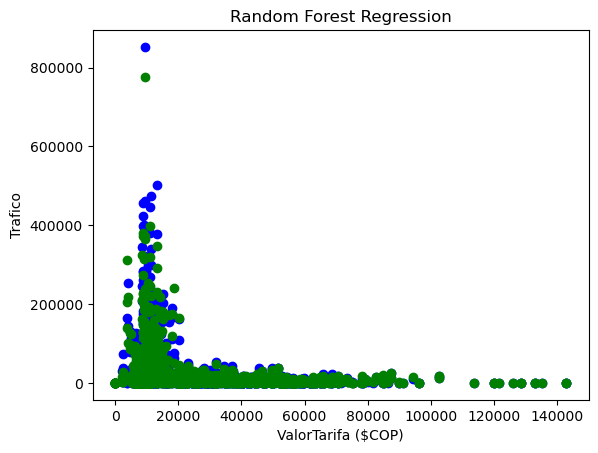

In [35]:
# Scatter plot for original data
plt.scatter(X22['ValorTarifa'], y22, color='blue')

# plot predicted data
plt.scatter(X22['ValorTarifa'], predictions, color='green')
plt.title('Random Forest Regression')
plt.xlabel('ValorTarifa ($COP)')
plt.ylabel('Trafico')

plt.show()